# GPU vs. CPU Running Time Test

We investigate the running time of GPytorch on CPU and GPU for training (60 iterations) and computing predictive distributions. For predictive distribution we also investigate the effect of LOVE approximation, so the scenarios are:
- CPU Exact
- GPU Exact
- CPU with LOVE without cache
- GPU with LOVE without cache
- CPU with LOVE with cache
- GPU with LOVE with cache

We use a customized Multitask Kernel with variable number of Kronecker Product, the same Kernel as used in Targeted Adaptive Design. We use 4 dimensional input and output.

The training and testing data are generated using sin and cos functions, etc.


In [1]:
# import caffeine
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
# from Data_Gen_Script import VField
import numpy as np
from scipy.stats import uniform

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch import nn
from torch import Tensor
from gpytorch.kernels import MultitaskKernel
from gpytorch.constraints import Positive




class TensorProductKernel(MultitaskKernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(self, data_covar_module,  num_tasks, rank=1, pos_constraint = None, tri_constaint = None, task_covar_prior=None, **kwargs):
        super().__init__(data_covar_module, num_tasks, rank, task_covar_prior = None, **kwargs)

        
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, add_jitter = False, **params):
        if last_dim_is_batch:
            raise RuntimeError("MultitaskKernel does not accept the last_dim_is_batch argument.")
        covar_i = self.task_covar_module.covar_matrix #.evaluate()
            
        covar_i = covar_i.evaluate()
        if len(x1.shape[:-2]):
            covar_i = covar_i.repeat(*x1.shape[:-2], 1, 1)
        covar_x = gpytorch.lazy.lazify(self.data_covar_module.forward(x1, x2, **params))#(self.data_covar_module.forward(x1, x2, **params))#
        if (add_jitter == True):
            covar_x = covar_x #+ (1e-6) * torch.eye(covar_x.shape[0])
        res=gpytorch.lazy.KroneckerProductLazyTensor(covar_x, covar_i) #gpytorch.lazy.lazify(torch.kron(covar_x, covar_i))

        return res.diag() if diag else res
        
        
from copy import deepcopy
from typing import List, Optional, Union

from torch.nn import ModuleList

from gpytorch.priors import Prior
from gpytorch.kernels import Kernel
from gpytorch.kernels import IndexKernel
from gpytorch.constraints import Positive

# This is the main Kernel to use

class SepTensorProductKernel(Kernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(
        self, base_kernels: List, num_tasks: int, rank: Union[int, List] = 1, 
        task_covar_prior: Optional[Prior] = None
    ):
        """
        Args:
            base_kernels (:type: list of `Kernel` objects): A list of base kernels.
            num_tasks (int): The number of output tasks to fit.
            rank (int): Rank of index kernel to use for task covariance matrix for each
                        of the base kernels.
            task_covar_prior (:obj:`gpytorch.priors.Prior`): Prior to use for each
                task kernel. See :class:`gpytorch.kernels.IndexKernel` for details.
        """
        if len(base_kernels) < 1:
            raise ValueError("At least one base kernel must be provided.")
        for k in base_kernels:
            if not isinstance(k, Kernel):
                raise ValueError("base_kernels must only contain Kernel objects")
        if not isinstance(rank, list):
            rank = [rank] * len(base_kernels)

        super(SepTensorProductKernel, self).__init__()
        self.covar_module_list = ModuleList(
            [
                TensorProductKernel(base_kernel, num_tasks=num_tasks, rank=r, task_covar_prior=task_covar_prior)
                for base_kernel, r in zip(base_kernels, rank)
            ]
        )

    def forward(self, x1, x2, **params):
        res = self.covar_module_list[0].forward(x1, x2, **params)
        for m in self.covar_module_list[1:]:
            res += m.forward(x1, x2, **params)
        return res

    def num_outputs_per_input(self, x1, x2):
        """
        Given `n` data points `x1` and `m` datapoints `x2`, this multitask kernel
        returns an `(n*num_tasks) x (m*num_tasks)` covariance matrix.
        """
        return self.covar_module_list[0].num_outputs_per_input(x1, x2)


    def __getitem__(self, index):
        new_kernel = deepcopy(self)
        new_kernel.covar_module_list = ModuleList(
            [base_kernel.__getitem__(index) for base_kernel in self.covar_module_list]
        )
        return new_kernel



In [3]:
"""
Model Initialization
"""

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
              gpytorch.means.ConstantMean(), num_tasks=Dval
        )
        
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) 
            #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = SepTensorProductKernel(base_kernels,num_tasks = Dval)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    

In [4]:
num_base_kernels = 8
cpu_training_time = []
cpu_exact_meancovar = []
cpu_love_meancovar = []
cpu_love_meancovar_cache = []

In [5]:
cpu_size_vec = [100,300,500,700,1000,1500,2000]
Nval = 4
Dval = 4

for size in cpu_size_vec:
    print(f"data size: {size}")
    """Set up the training and testing data"""
    n = size # input size

    x = torch.stack([
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
    ], -1)

    """ 
    loc=np.array([0, 6, 2, 4])
    vec=np.array([0, 5, -2, 10])

    vfield = VField(N=Nval, D=Dval, tgt_loc=loc, tgt_vec=vec, polynomial_order=3)
    y = vfield(x)
    """

    y = torch.stack([
        torch.sin(x[:, 0] * (2 * math.pi)) + torch.randn(n) * 0.02,
        torch.cos(x[:, 1] * (2 * math.pi)) + torch.randn(n) * 0.02,
        torch.sin(x[:, 2] * (2 * math.pi)) + torch.cos(x[:, 1] * (2 * math.pi)) + torch.randn(n) * 0.02,
        (torch.cos(x[:, 3] * (2 * math.pi)))* (torch.sin(x[:, 0] * (2 * math.pi))) + torch.randn(n) * 0.02,
    ], -1)

    train_x = torch.Tensor(x[:int(0.8*n), :])
    train_y = y[:int(0.8*n), :]

    test_x = torch.Tensor(x[int(0.8*n):, :])

    test_y = torch.Tensor(y[int(0.8*n):, :])

#     # normalize features
#     mean = train_x.mean(dim=-2, keepdim=True)
#     std = train_x.std(dim=-2, keepdim=True) # + 1e-6 # prevent dividing by 0
#     train_x = (train_x - mean) / std
#     test_x = (test_x - mean) / std

#     # normalize labels
#     mean, std = train_y.mean(),train_y.std()
#     train_y = (train_y - mean) / std
#     test_y = (test_y - mean) / std

#     norm_vec = (vec - mean) / std
    
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_base_kernels)
    
    start_time = time.time()
    
    """train the model hyperparameters"""
    import os
    smoke_test = ('CI' in os.environ)
    training_iterations = 2 if smoke_test else 60

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with gpytorch.settings.max_cg_iterations(1000):
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
#           if(i > training_iterations*0.8):
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            optimizer.step()
    
    cpu_training_time.append(time.time() - start_time)
    
    print()
    
    """ Making predictions with the model"""
    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Exact predictions
    with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x) # no noise
        covar = preds.covariance_matrix
        cpu_exact_meancovar.append(time.time() - start_time)
    
    
    
    # LOVE without cache
        # Clear the cache from the previous computations
    model.train()
    likelihood.train()
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        cpu_love_meancovar.append(time.time() - start_time)
    
    # LOVE with cache
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        cpu_love_meancovar_cache.append(time.time() - start_time)  


data size: 100
Iter 1/60 - Loss: 1.367


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /lus/theta-fs0/software/thetagpu/conda/2022-07-01/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 2/60 - Loss: 1.318
Iter 3/60 - Loss: 1.274
Iter 4/60 - Loss: 1.233
Iter 5/60 - Loss: 1.195
Iter 6/60 - Loss: 1.155
Iter 7/60 - Loss: 1.113
Iter 8/60 - Loss: 1.072
Iter 9/60 - Loss: 1.031
Iter 10/60 - Loss: 0.991
Iter 11/60 - Loss: 0.951
Iter 12/60 - Loss: 0.912
Iter 13/60 - Loss: 0.871
Iter 14/60 - Loss: 0.830
Iter 15/60 - Loss: 0.788
Iter 16/60 - Loss: 0.745
Iter 17/60 - Loss: 0.703
Iter 18/60 - Loss: 0.662
Iter 19/60 - Loss: 0.621
Iter 20/60 - Loss: 0.580
Iter 21/60 - Loss: 0.540
Iter 22/60 - Loss: 0.500
Iter 23/60 - Loss: 0.461
Iter 24/60 - Loss: 0.422
Iter 25/60 - Loss: 0.384
Iter 26/60 - Loss: 0.347
Iter 27/60 - Loss: 0.310
Iter 28/60 - Loss: 0.274
Iter 29/60 - Loss: 0.239
Iter 30/60 - Loss: 0.205
Iter 31/60 - Loss: 0.172
Iter 32/60 - Loss: 0.140
Iter 33/60 - Loss: 0.108
Iter 34/60 - Loss: 0.077
Iter 35/60 - Loss: 0.046
Iter 36/60 - Loss: 0.014
Iter 37/60 - Loss: -0.017
Iter 38/60 - Loss: -0.049
Iter 39/60 - Loss: -0.081
Iter 40/60 - Loss: -0.114
Iter 41/60 - Loss: -0.148
Ite

Iter 23/60 - Loss: 0.242
Iter 24/60 - Loss: 0.196
Iter 25/60 - Loss: 0.146
Iter 26/60 - Loss: 0.096
Iter 27/60 - Loss: 0.046
Iter 28/60 - Loss: -0.002
Iter 29/60 - Loss: -0.052
Iter 30/60 - Loss: -0.105
Iter 31/60 - Loss: -0.149
Iter 32/60 - Loss: -0.202
Iter 33/60 - Loss: -0.254
Iter 34/60 - Loss: -0.296
Iter 35/60 - Loss: -0.352
Iter 36/60 - Loss: -0.405
Iter 37/60 - Loss: -0.452
Iter 38/60 - Loss: -0.504
Iter 39/60 - Loss: -0.552
Iter 40/60 - Loss: -0.599
Iter 41/60 - Loss: -0.655
Iter 42/60 - Loss: -0.703
Iter 43/60 - Loss: -0.754
Iter 44/60 - Loss: -0.803
Iter 45/60 - Loss: -0.852
Iter 46/60 - Loss: -0.908
Iter 47/60 - Loss: -0.957
Iter 48/60 - Loss: -1.005
Iter 49/60 - Loss: -1.053
Iter 50/60 - Loss: -1.106
Iter 51/60 - Loss: -1.148
Iter 52/60 - Loss: -1.197
Iter 53/60 - Loss: -1.240
Iter 54/60 - Loss: -1.291
Iter 55/60 - Loss: -1.339
Iter 56/60 - Loss: -1.383
Iter 57/60 - Loss: -1.432
Iter 58/60 - Loss: -1.487
Iter 59/60 - Loss: -1.524
Iter 60/60 - Loss: -1.577

data size: 2000


In [6]:
print(cpu_training_time)
print(cpu_exact_meancovar)
print(cpu_love_meancovar)
print(cpu_love_meancovar_cache)

[3.7215499877929688, 9.794497728347778, 14.904312372207642, 21.27997350692749, 32.48446846008301, 53.88267135620117, 81.62078332901001]
[0.09543967247009277, 4.492389917373657, 18.700906991958618, 20.917333364486694, 65.99183177947998, 246.90132880210876, 582.1835989952087]
[0.08900070190429688, 0.7966694831848145, 1.2842626571655273, 1.385444164276123, 3.100579023361206, 6.697657585144043, 15.783673286437988]
[0.014788627624511719, 0.0886070728302002, 0.11827206611633301, 0.20630216598510742, 0.39751195907592773, 0.8935346603393555, 1.9156162738800049]


In [7]:
# # Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(15, 10))

# # This contains predictions for both tasks, flattened out
# # The first half of the predictions is for the first task
# # The second half is for the second task

# # Plot training data as black stars
# y1_ax.plot(train_x[:, 0].detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# # Predictive mean as blue line
# y1_ax.plot(test_x[:, 0].numpy(), preds.mean[:, 0].numpy(), 'b')
# # Shade in confidence
# # y1_ax.fill_between(test_x[:, 0].numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
# # y1_ax.set_ylim([-3, 3])
# y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y1_ax.set_title('Observed Values (Likelihood)')

# # Plot training data as black stars
# y2_ax.plot(train_x[:, 1].detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# # Predictive mean as blue line
# y2_ax.plot(test_x[:, 1].numpy(), preds.mean[:, 1].numpy(), 'b')
# # Shade in confidence
# # y2_ax.fill_between(test_x[:, 1].numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
# # y2_ax.set_ylim([-3, 3])
# y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y2_ax.set_title('Observed Values (Likelihood)')

# None

In [8]:
gpu_training_time = []
gpu_exact_meancovar = []
gpu_love_meancovar = []
gpu_love_meancovar_cache = []

In [9]:
gpu_size_vec = [100,300,500,700,1000,1500,2000,3000,4000,5000,6000,7000]
Nval = 4
Dval = 4

for size in gpu_size_vec:
    print(f"data size: {size}")
    """Set up the training and testing data"""
    n = size # input size

    x = torch.stack([
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
        torch.linspace(0, 5, n),
    ], -1)

    """ 
    loc=np.array([0, 6, 2, 4])
    vec=np.array([0, 5, -2, 10])

    vfield = VField(N=Nval, D=Dval, tgt_loc=loc, tgt_vec=vec, polynomial_order=3)
    y = vfield(x)
    """

    y = torch.stack([
        torch.sin(x[:, 0] * (2 * math.pi)) + torch.randn(n) * 0.02,
        torch.cos(x[:, 1] * (2 * math.pi)) + torch.randn(n) * 0.02,
        torch.sin(x[:, 2] * (2 * math.pi)) + torch.randn(n) * 0.02,
        torch.cos(x[:, 3] * (2 * math.pi)) + torch.randn(n) * 0.02,
    ], -1)

    train_x = torch.Tensor(x[:int(0.8*n), :])
    train_y = y[:int(0.8*n), :]

    test_x = torch.Tensor(x[int(0.8*n):, :])

    test_y = torch.Tensor(y[int(0.8*n):, :])

#     # normalize features
#     mean = train_x.mean(dim=-2, keepdim=True)
#     std = train_x.std(dim=-2, keepdim=True) # + 1e-6 # prevent dividing by 0
#     train_x = (train_x - mean) / std
#     test_x = (test_x - mean) / std

#     # normalize labels
#     mean, std = train_y.mean(),train_y.std()
#     train_y = (train_y - mean) / std
#     test_y = (test_y - mean) / std

#     norm_vec = (vec - mean) / std
    
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_base_kernels)
    
    start_time = time.time() # include the time of copying values onto gpu
    
    use_cuda = torch.cuda.is_available()
    print(f"Use Cuda: {use_cuda}")
    if(use_cuda):
        train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
        model, likelihood = model.cuda(), likelihood.cuda()
    
    """train the model hyperparameters"""
    import os
    smoke_test = ('CI' in os.environ)
    training_iterations = 2 if smoke_test else 60

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with gpytorch.settings.max_cg_iterations(1000):
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
#           if(i > training_iterations*0.8):
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            optimizer.step()
    
    gpu_training_time.append(time.time() - start_time)
    
    print()
    
    """ Making predictions with the model"""
    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Exact predictions
    with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x) # no noise
        covar = preds.covariance_matrix
        gpu_exact_meancovar.append(time.time() - start_time)
    
    
    
    # LOVE without cache
        # Clear the cache from the previous computations
    model.train()
    likelihood.train()
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        gpu_love_meancovar.append(time.time() - start_time)
    
    # LOVE with cache
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        gpu_love_meancovar_cache.append(time.time() - start_time)  


data size: 100
Use Cuda: True
Iter 1/60 - Loss: 1.345
Iter 2/60 - Loss: 1.297
Iter 3/60 - Loss: 1.254
Iter 4/60 - Loss: 1.216
Iter 5/60 - Loss: 1.177
Iter 6/60 - Loss: 1.137
Iter 7/60 - Loss: 1.095
Iter 8/60 - Loss: 1.053
Iter 9/60 - Loss: 1.011
Iter 10/60 - Loss: 0.970
Iter 11/60 - Loss: 0.929
Iter 12/60 - Loss: 0.887
Iter 13/60 - Loss: 0.843
Iter 14/60 - Loss: 0.799
Iter 15/60 - Loss: 0.755
Iter 16/60 - Loss: 0.710
Iter 17/60 - Loss: 0.665
Iter 18/60 - Loss: 0.620
Iter 19/60 - Loss: 0.574
Iter 20/60 - Loss: 0.528
Iter 21/60 - Loss: 0.481
Iter 22/60 - Loss: 0.434
Iter 23/60 - Loss: 0.387
Iter 24/60 - Loss: 0.340
Iter 25/60 - Loss: 0.293
Iter 26/60 - Loss: 0.246
Iter 27/60 - Loss: 0.198
Iter 28/60 - Loss: 0.150
Iter 29/60 - Loss: 0.102
Iter 30/60 - Loss: 0.054
Iter 31/60 - Loss: 0.007
Iter 32/60 - Loss: -0.041
Iter 33/60 - Loss: -0.089
Iter 34/60 - Loss: -0.137
Iter 35/60 - Loss: -0.185
Iter 36/60 - Loss: -0.233
Iter 37/60 - Loss: -0.280
Iter 38/60 - Loss: -0.328
Iter 39/60 - Loss: -0.

Iter 18/60 - Loss: 0.470
Iter 19/60 - Loss: 0.425
Iter 20/60 - Loss: 0.376
Iter 21/60 - Loss: 0.329
Iter 22/60 - Loss: 0.281
Iter 23/60 - Loss: 0.234
Iter 24/60 - Loss: 0.185
Iter 25/60 - Loss: 0.135
Iter 26/60 - Loss: 0.086
Iter 27/60 - Loss: 0.039
Iter 28/60 - Loss: -0.009
Iter 29/60 - Loss: -0.059
Iter 30/60 - Loss: -0.112
Iter 31/60 - Loss: -0.160
Iter 32/60 - Loss: -0.211
Iter 33/60 - Loss: -0.263
Iter 34/60 - Loss: -0.312
Iter 35/60 - Loss: -0.364
Iter 36/60 - Loss: -0.415
Iter 37/60 - Loss: -0.465
Iter 38/60 - Loss: -0.517
Iter 39/60 - Loss: -0.567
Iter 40/60 - Loss: -0.618
Iter 41/60 - Loss: -0.668
Iter 42/60 - Loss: -0.723
Iter 43/60 - Loss: -0.770
Iter 44/60 - Loss: -0.823
Iter 45/60 - Loss: -0.877
Iter 46/60 - Loss: -0.925
Iter 47/60 - Loss: -0.978
Iter 48/60 - Loss: -1.028
Iter 49/60 - Loss: -1.080
Iter 50/60 - Loss: -1.132
Iter 51/60 - Loss: -1.182
Iter 52/60 - Loss: -1.230
Iter 53/60 - Loss: -1.277
Iter 54/60 - Loss: -1.328
Iter 55/60 - Loss: -1.378
Iter 56/60 - Loss: -1.

Iter 35/60 - Loss: -0.391
Iter 36/60 - Loss: -0.441
Iter 37/60 - Loss: -0.494
Iter 38/60 - Loss: -0.545
Iter 39/60 - Loss: -0.597
Iter 40/60 - Loss: -0.649
Iter 41/60 - Loss: -0.700
Iter 42/60 - Loss: -0.750
Iter 43/60 - Loss: -0.803
Iter 44/60 - Loss: -0.855
Iter 45/60 - Loss: -0.905
Iter 46/60 - Loss: -0.957
Iter 47/60 - Loss: -1.009
Iter 48/60 - Loss: -1.061
Iter 49/60 - Loss: -1.113
Iter 50/60 - Loss: -1.164
Iter 51/60 - Loss: -1.215
Iter 52/60 - Loss: -1.264
Iter 53/60 - Loss: -1.316
Iter 54/60 - Loss: -1.364
Iter 55/60 - Loss: -1.411
Iter 56/60 - Loss: -1.461
Iter 57/60 - Loss: -1.510
Iter 58/60 - Loss: -1.562
Iter 59/60 - Loss: -1.614
Iter 60/60 - Loss: -1.663

data size: 7000
Use Cuda: True
Iter 1/60 - Loss: 1.092
Iter 2/60 - Loss: 1.083
Iter 3/60 - Loss: 1.051
Iter 4/60 - Loss: 1.017
Iter 5/60 - Loss: 0.982
Iter 6/60 - Loss: 0.946
Iter 7/60 - Loss: 0.908
Iter 8/60 - Loss: 0.871
Iter 9/60 - Loss: 0.830
Iter 10/60 - Loss: 0.791
Iter 11/60 - Loss: 0.750
Iter 12/60 - Loss: 0.708
I

/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.22459891438484192 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [10]:
print(gpu_training_time)
print(gpu_exact_meancovar)
print(gpu_love_meancovar)
print(gpu_love_meancovar_cache)

[5.1458351612091064, 3.7927017211914062, 3.786275863647461, 6.021966218948364, 6.551958799362183, 7.098454475402832, 7.526453733444214, 8.59511399269104, 9.536357879638672, 11.618726968765259, 13.954174518585205, 15.526504516601562]
[0.3653292655944824, 0.6142899990081787, 0.6227104663848877, 0.4550042152404785, 0.7036929130554199, 2.3196699619293213, 5.288795232772827, 16.791099548339844, 53.61664700508118, 126.55413103103638, 219.55472016334534, 551.2603468894958]
[0.03246808052062988, 0.38523292541503906, 0.4070422649383545, 0.33737707138061523, 0.34267425537109375, 0.4143664836883545, 0.4390983581542969, 0.6811835765838623, 0.8329904079437256, 1.1819615364074707, 1.6758544445037842, 2.9778125286102295]
[0.01569986343383789, 0.03600311279296875, 0.03662705421447754, 0.041841745376586914, 0.039226531982421875, 0.04852437973022461, 0.0659933090209961, 0.1307201385498047, 0.2516911029815674, 0.44244813919067383, 0.7251169681549072, 1.1042866706848145]


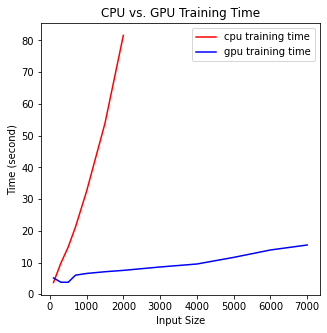

In [11]:
# # plot with various axes scales
# plt.figure()

# CPU vs GPU training
plt.figure(figsize=(5,5))
plt.plot(cpu_size_vec, cpu_training_time, 'r-', label='cpu training time')
plt.plot(gpu_size_vec, gpu_training_time, 'b-', label='gpu training time')
plt.ylabel('Time (second)')
plt.xlabel('Input Size')
plt.title('CPU vs. GPU Training Time')
# plt.grid(True)



plt.legend()
plt.show()

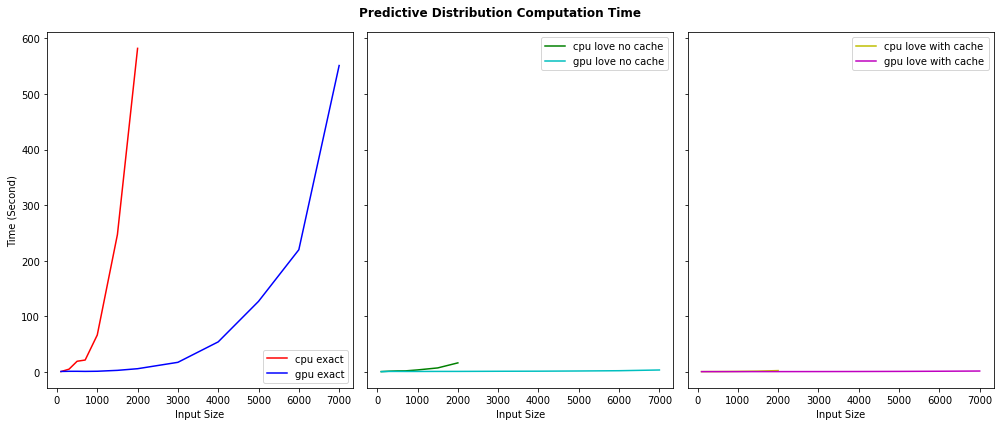

In [12]:
# Predictive Distribution Computation Time

# # Initialize plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

plt.suptitle('Predictive Distribution Computation Time', fontweight='bold')

ax1.plot(cpu_size_vec, cpu_exact_meancovar, 'r-', label='cpu exact')
ax1.plot(gpu_size_vec, gpu_exact_meancovar, 'b-', label='gpu exact')
ax1.legend()


plt.subplot(132)
ax2.plot(cpu_size_vec, cpu_love_meancovar, 'g-', label='cpu love no cache')
ax2.plot(gpu_size_vec, gpu_love_meancovar, 'c-', label='gpu love no cache')
ax2.legend()
# plt.ylabel('Time')
# plt.xlabel('Input Size')

plt.subplot(133)
ax3.plot(cpu_size_vec, cpu_love_meancovar_cache, 'y-', label='cpu love with cache')
ax3.plot(gpu_size_vec, gpu_love_meancovar_cache, 'm-', label='gpu love with cache')
ax3.legend()

plt.setp([ax1,ax2,ax3], xlabel='Input Size')
plt.setp(ax1, ylabel='Time (Second)')

plt.legend()
plt.tight_layout()